# Cross-Assay Integrative Analyses

In [11]:
import polars as pl
import os
import seaborn as sns
import glob
import matplotlib.pyplot as plt
from venn import venn
%matplotlib inline

## 1. Loading allele information

### 1.1 VarChAMP Dataset Alleles Merged with Pillar Project

In [2]:
varchamp_pillar_df = pl.read_csv("../../1_allele_collection/3_outputs/varchamp_alleles_with_pillar_annotations.tsv", 
                                 separator="\t", infer_schema_length=1000000)
print("VarChAMP dataset shape:", varchamp_pillar_df.shape)

VarChAMP dataset shape: (129900, 586)


In [4]:
print("Overlapped unique gene variants between VarChAMP and Pillar Project:")
varchamp_pillar_df.filter(pl.col("pillar_tested")).unique("gene_variant")

Overlapped unique gene variants between VarChAMP and Pillar Project:


symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,dualip_sequenced,dualip_sequence_confirmation_class,dualip_ref_sequence_confirmation_class,mislocalization_sequenced,mislocalization_sequence_confirmation_class,mislocalization_ref_sequence_confirmation_class,gene_variant,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,…,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""F9""","""ENSG00000101981""",52861,204397,"""CCSBVarC004391""","""ALE00004391""","""NC_000023.11:139561872:G:C""","""1187G>C""","""Cys396Ser""","""CEGS2""","""CegsMutGDEh1019""","""B07""","""GDEhDisVCh_40052""","""D04""","""2""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""F9_Cys396Ser""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""F9_Cys396Ser""","""Cys396Ser""",true
"""CBS""","""ENSG00000160200""",359,299,"""CCSBVarC007343""","""ALE00007332""","""NC_000021.9:43066297:C:T""","""397G>A""","""Asp133Asn""","""Edgotyping3""","""VUSMutGDEh011""","""B04""","""GDEhDisVCh_40013""","""D09""","""1""","""VUSMutGDDh011""","""B04""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,6,0,null,null,0,null,null,0,null,null,"""CBS_Asp133Asn""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,"""CBS_Asp133Asn""","""Asp133Asn""",true
"""TP53""","""ENSG00000141510""",3774,214907,"""CCSBVarC004871""","""ALE00004871""","""NC_000017.11:7673820:C:T""","""800G>A""","""Arg267Gln""","""CEGS2""","""CegsMutGDEh1023""","""F12""","""GDEhDisVCh_40053""","""B08""","""1""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,0,null,0,null,null,0,null,null,0,null,null,"""TP53_Arg267Gln""",…,null,null,null,1.290704,21.481362,2.15,1.0,1.0,59.611072,0.1,0.868826,"""VUS""",null,null,null,127823.0,"""CA000424""","""Li-Fraumeni syndrome""","""MONDO:0018875""","""Autosomal dominant inheritance""","""Uncertain Significance""","""PS4_Supporting,PP3,BS3_Support…","""P

In [5]:
# pillar_clinvar_df = pl.read_csv(
#     "../../1_allele_collection/1_inputs/raw_inputs/pillar_data/pillar_data_clinvar38_053125_wREVEL_gold_standards.csv", 
#     schema_overrides={
#         "Chrom": pl.String, 
#         'aa_pos': pl.String, 
#         'auth_reported_score': pl.String
#     },
#     infer_schema_length=10000
# ).with_columns(
#     pl.col("Gene").str.replace_all(r"[^a-zA-Z0-9]", "").alias("Gene"),
#     pl.col("hgvs_p").str.replace_all(r"[^a-zA-Z0-9\.]", "").alias("hgvs_p")
# ).with_columns(
#     pl.col("Gene").str.replace_all("CHK2", "CHEK2").alias("Gene"),
#     pl.col("Chrom").cast(pl.String).str.strip_chars().alias("Chrom"),
#     pl.col("hg38_start").alias("nuc_loc"),
#     pl.col("ref_allele").cast(pl.String).str.strip_chars().alias("ref_allele"),
#     pl.col("alt_allele").cast(pl.String).str.strip_chars().alias("alt_allele")
# ).with_columns(
#     pl.concat_str(
#         [
#             pl.col("Gene"),
#             pl.col("hgvs_p").str.replace(r"^p\.", "") # remove leading "p." from hgvs_p
#         ],
#         separator="_"
#     ).alias("gene_variant")
# )
# print("Original pillar dataset shape:", pillar_clinvar_df.shape)

# ## filter the SNP variants only
# pillar_clinvar_single_aa_df = pillar_clinvar_df.filter(
#     (pl.col("consequence").str.contains("sense")) & \
#     (pl.col("ref_allele").str.len_chars()==1) & (pl.col("alt_allele").str.len_chars()==1) & \
#     (pl.col("hg38_start").is_not_null()) & (pl.col("hg38_end").is_not_null())
# ).drop_nulls(subset="hgvs_p").with_columns(
#     pl.col("hgvs_p").str.split(".").list.get(-1).alias("aa_change"),
#     pl.lit(True).alias("pillar_tested")
# )
# print("Filtered missense/SNP pillar dataset shape:", pillar_clinvar_single_aa_df.shape)

# pillar_clinvar_single_aa_df = pillar_clinvar_single_aa_df.sort(
#     "gene_variant", "gnomad_MAF", descending=[False,False]
# )
# print("Number of unique genes:", pillar_clinvar_single_aa_df.unique(subset="Gene").shape[0])
# print("Number of unique gene variants:", pillar_clinvar_single_aa_df.unique(subset="gene_variant").shape[0])
# display(pillar_clinvar_single_aa_df) #.filter(pl.col("Ref_seq_transcript_ID").str.contains("NC_"))

### 1.2 Imaging Data

In [7]:
img_metric_df = pl.DataFrame()
img_metric_df = pl.read_csv("../1_inputs/imaging/imaging_analyses_summary_clinvar.tsv", separator="\t", infer_schema_length=100000)
img_metric_df = img_metric_df.with_columns(
    pl.col("gene_allele").alias("gene_variant")
)
print("VarChAMP Imaging assay unique variants:", img_metric_df.unique(subset=["gene_variant"]).shape[0])

VarChAMP Imaging assay unique variants: 475


### 1.3 DUAL-IPA and PPI alleles

In [16]:
dual_ipa_df = pl.read_csv("../1_inputs/dual_ipa/abun_scores.csv", infer_schema_length=1000000)
display(dual_ipa_df)
print("VarChAMP DUAL-IPA assay unique variants:", dual_ipa_df.unique(subset=["gene_variant"]).shape[0])
ppi_sum_df = pl.read_csv("../1_inputs/ppi/edgotyping_perturb_sum_stats.csv", infer_schema_length=1000000)
display(ppi_sum_df)
print("VarChAMP DUAL-IPA assay unique variants:", ppi_sum_df.unique(subset=["gene_variant"]).shape[0])

# ## merge the two assays by gene_variant
# dual_ppi_df = dual_ipa_df.join(
#     ppi_sum_df,
#     left_on="gene_variant",
#     right_on="gene_variant",
#     how="full",
#     coalesce=True,
#     suffix="_ppi"
# )
# print("VarChAMP DUAL-IPA and PPI assay unique variants:", dual_ppi_df.unique(subset=["gene_variant"]).shape[0])

# dual_ppi_set = {
#     'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
#     'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
# }

# venn(dual_ppi_set)
# plt.title("DUAL-IPA and PPI Venn/Euler diagram")
# plt.show()

symbol,nt_change,aa_change,gene_variant,median_gfp,median_mcherry,median_GFP_mCherry_ratio,wt_GFP_mCherry_ratio_median,allele_wt_ratio_median,zscore_median,zcat_median,zscore_log2,ensembl_gene_id,ccsb_mutation_id,ccsb_allele_id,spdi,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,n2h_sequence_confirmation_class,n2h_ref_sequence_confirmation_class,…,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested,dualipa_abund_change,dualipa_assayed,dualipa_threshold
str,str,str,str,f64,f64,f64,f64,f64,f64,f64,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool,bool,bool,f64
"""KCNJ2""","""899G>A""","""Gly300Asp""","""KCNJ2_Gly300Asp""",693.679993,5069.049805,0.133067,0.841771,0.15808,-1.835174,-1.0,-5.882805,"""ENSG00000123700""","""CCSBVarC008343""","""ALE00008329""","""NC_000017.11:70175938:G:A""","""Edgotyping3""","""VUSMutGDEh010""","""G06""","""GDEhDisVCh_40005""","""F10""","""1""","""VUSMutGDDh010""","""G06""","""VUSN2Hmut_GDN2h_03""","""H09""","""VUSMutpDEST2_16""","""G04""","""VUSmut_GDEh03""","""H09""",1,2,1,2,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.477405
"""HBD""","""174C>A""","""Asn58Lys""","""HBD_Asn58Lys""",33.84,2474.280029,0.012192,0.077713,0.156882,-1.837623,-1.0,-5.907103,"""ENSG00000223609""","""CCSBVarC006560""","""ALE00006559""","""NC_000011.10:5234132:G:T""","""CEGS2""","""CegsMutGDEh1047""","""D02""","""GDEhDisVCh_40036""","""D03""","""2""","""CegsMutGDDh1047""","""D02""","""VUSN2Hmut_GDN2h_10""","""C04""","""VUSMutpDEST2_11""","""H05""","""VUSmut_GDEh10""","""C04""",1,1,1,1,1,5,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.477405
"""SMAD3""","""376C>T""","""His126Tyr""","""SMAD3_His126Tyr""",993.600037,3757.339966,0.267095,1.033889,0.25834,-1.630252,-1.0,-4.313822,"""ENSG00000166949""","""CCSBVarC007714""","""ALE00007700""","""NC_000015.10:67165064:C:T""","""Edgotyping3""","""VUSMutGDEh004""","""D11""","""GDEhDisVCh_40014""","""D06""","""2""","""VUSMutGDDh004""","""D11""","""NULL""","""NULL""","""VUSMutpDEST2_09""","""B02""","""NULL""","""NULL""",1,1,1,1,0,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,true,true,-2.477405
"""HBD""","""110C>A""","""Pro37His""","""HBD_Pro37His""",31.9

VarChAMP DUAL-IPA assay unique variants: 741


gene_variant,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage,ppi_assayed,symbol,ensembl_gene_id,orf_id,mut_id,ccsb_mutation_id,ccsb_allele_id,spdi,nt_change,aa_change,collection,entry_plate_orig,entry_well_orig,entry_plate_conso,entry_well_conso,entry_seq_pool,db_plate,db_well,n2h_plate,n2h_well,dualip_plate,dualip_well,mislocalization_plate,mislocalization_well,entry_sequenced,entry_sequence_confirmation_class,db_sequenced,db_sequence_confirmation_class,n2h_sequenced,…,Naive_prior_prob_PMID:31131967,Calcualted_post_prob_PMID:31131967,calculated_classification_PMID:31131967,SGR LR_PMID:34273903,Personal and Family History LR (Combined)_PMID:34273903,Breast Tumor Pathology LR_PMID:34273903,Population Allele Frequency LR_PMID:34273903,BS2 LR_PMID:34273903,Calculated_combined_LR_PMID:34273903,Naive_prior_prob_PMID:34273903,Calculated_post_prob_PMID:34273903,calculated_classification_PMID:34273903,Reference Group*_presumed_PMID:34273903,Component_presumed_PMID:34273903,Rationale_presumed_PMID:34273903,ClinVar Variation Id_ClinGen_repo,Allele Registry Id_ClinGen_repo,Disease_ClinGen_repo,Mondo Id_ClinGen_repo,Mode of Inheritance_ClinGen_repo,Assertion_ClinGen_repo,Applied Evidence Codes (Met)_ClinGen_repo,Applied Evidence Codes (Not Met)_ClinGen_repo,Summary of interpretation_ClinGen_repo,PubMed Articles_ClinGen_repo,Expert Panel_ClinGen_repo,Guideline_ClinGen_repo,Approval Date_ClinGen_repo,Published Date_ClinGen_repo,Retracted_ClinGen_repo,Evidence Repo Link_ClinGen_repo,Uuid_ClinGen_repo,Updated_Classification_ClinGen_repo,Updated_Evidence Codes_ClinGen_repo,gene_variant_pp,aa_change_pp,pillar_tested
str,i64,i64,i64,i64,f64,f64,f64,bool,str,str,i64,i64,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,i64,i64,i64,i64,i64,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""HBD_Arg105Ser""",2,1,0,1,50.0,0.0,50.0,true,"""HBD""","""ENSG00000223609""",13796,218148,"""CCSBVarC006562""","""ALE00006561""","""NC_000011.10:5233991:C:A""","""315G>T""","""Arg105Ser""","""CEGS2""","""CegsMutGDEh1044""","""E11""","""GDEhDisVCh_40036""","""C02""","""2""","""CegsMutGDDh1044""","""E11""","""VUSN2Hmut_GDN2h_09""","""G07""","""VUSMutpDEST2_11""","""B06""","""VUSmut_GDEh09""","""G07""",1,1,1,1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""STXBP1_Arg505His""",6,2,2,1,33.33,33.33,16.67,true,"""STXBP1""","""ENSG00000136854""",7652,1838,"""CCSBVarC007655""","""ALE00007641""","""NC_000009.12:127680209:G:A""","""1514G>A""","""Arg505His""","""Edgotyping3""","""VUSMutGDEh008""","""C12""","""GDEhDisVCh_40016""","""H09""","""2""","""VUSMutGDDh008""","""C12""","""VUSN2Hmut_GDN2h_02""","""F11""","""VUSMutpDEST2_06""","""G10""","""VUSmut_GDEh02""","""F11""",1,1,1,1,1,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""TSFM_Arg255Cys""",5,0,1,1,0.0,20.0,20.0,true,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""VHL_Ser65Trp""",1,0,1,0,0.0,100.0,0.0,true,"""VHL""","""ENSG00000134086""",13320,22229,"""CCSBVarC001963""","""ALE00001963""","""NC_000003.12:10142041:C:G""","""194C>G""","""Ser65Trp""","""RC4""","""RC4_Mut_GDEh1011""","""G10""","""GDEhDisVCh_40037""","""C09""","""1""","""RC4_Mut_GDDh1011""","""G10""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""","""NULL""",1,1,1,99,0,…,nu

VarChAMP DUAL-IPA assay unique variants: 819


<Axes: xlabel='zscore_log2', ylabel='perturbed_percentage'>

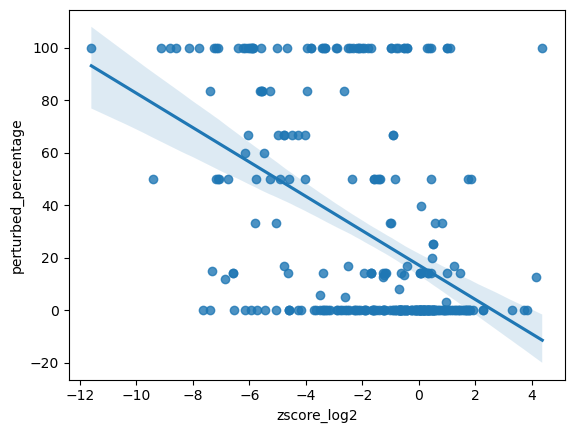

In [18]:
sns.regplot(data=dual_ppi_df.to_pandas(),
            x="zscore_log2",
            y="perturbed_percentage")

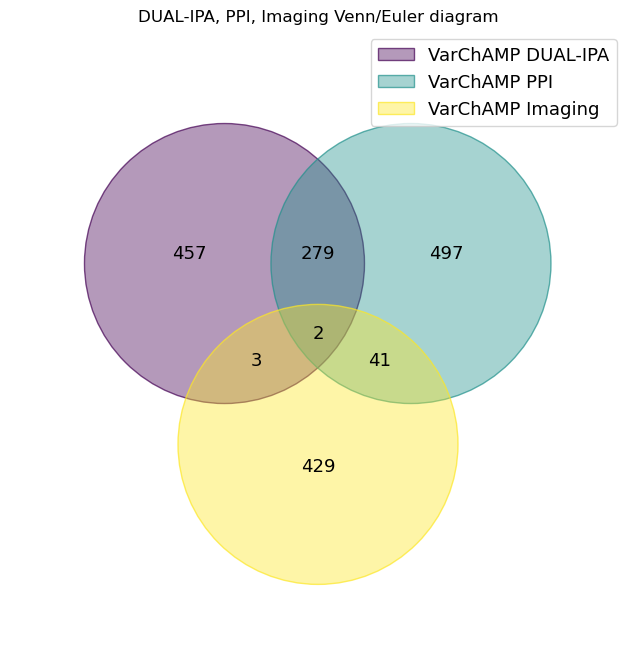

In [19]:
# Create the diagrams with your data
dual_ppi_img_set = {
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique())
}

venn(dual_ppi_img_set)
plt.title("DUAL-IPA, PPI, Imaging Venn/Euler diagram")
plt.show()

In [21]:
img_dual_ppi_df = img_metric_df.join( ## .unique(subset=["gene_variant"])
    dual_ipa_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_dualipa"
).join( ## .unique(subset=["gene_variant"])
    ppi_sum_df,
    left_on="gene_variant",
    right_on="gene_variant",
    how="full",
    coalesce=True,
    suffix="_ppi"
)

img_dual_ppi_df = img_dual_ppi_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
)
img_dual_ppi_df.unique("gene_variant")

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,…,Naive_prior_prob_PMID:31131967_ppi,Calcualted_post_prob_PMID:31131967_ppi,calculated_classification_PMID:31131967_ppi,SGR LR_PMID:34273903_ppi,Personal and Family History LR (Combined)_PMID:34273903_ppi,Breast Tumor Pathology LR_PMID:34273903_ppi,Population Allele Frequency LR_PMID:34273903_ppi,BS2 LR_PMID:34273903_ppi,Calculated_combined_LR_PMID:34273903_ppi,Naive_prior_prob_PMID:34273903_ppi,Calculated_post_prob_PMID:34273903_ppi,calculated_classification_PMID:34273903_ppi,Reference Group*_presumed_PMID:34273903_ppi,Component_presumed_PMID:34273903_ppi,Rationale_presumed_PMID:34273903_ppi,ClinVar Variation Id_ClinGen_repo_ppi,Allele Registry Id_ClinGen_repo_ppi,Disease_ClinGen_repo_ppi,Mondo Id_ClinGen_repo_ppi,Mode of Inheritance_ClinGen_repo_ppi,Assertion_ClinGen_repo_ppi,Applied Evidence Codes (Met)_ClinGen_repo_ppi,Applied Evidence Codes (Not Met)_ClinGen_repo_ppi,Summary of interpretation_ClinGen_repo_ppi,PubMed Articles_ClinGen_repo_ppi,Expert Panel_ClinGen_repo_ppi,Guideline_ClinGen_repo_ppi,Approval Date_ClinGen_repo_ppi,Published Date_ClinGen_repo_ppi,Retracted_ClinGen_repo_ppi,Evidence Repo Link_ClinGen_repo_ppi,Uuid_ClinGen_repo_ppi,Updated_Classification_ClinGen_repo_ppi,Updated_Evidence Codes_ClinGen_repo_ppi,gene_variant_pp_ppi,aa_change_pp_ppi,pillar_tested_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""EIF2B4""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""AGXT""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""SH3BP2""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""MVK""",null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""ZC4H2""","""ZC4H2_Pro201Ser""",5.809681,0.002975,-3.412556,0.058483,"""2025_01_Batch_13-14""",0.631726,0.717563,0.70676,0.723719,0.6348,0.78144,0.834879,0.897882,0.838226,0.700547,0.706583,0.776221,0.802321,0.780972,0.667674,0.0,0.0,0.0,0.0,0.0,

In [22]:
img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))&(pl.col("dualipa_assayed")))

Gene,gene_allele,U2OS_cc_t_stat,U2OS_cc_t_pval,U2OS_abun_t_stat,U2OS_abun_t_pval,Metadata_Bio_Batch,AUROC_BioRep1_Morph,AUROC_BioRep1_AGP,AUROC_BioRep1_GFP,AUROC_BioRep1_Mito,AUROC_BioRep1_DNA,AUROC_BioRep2_Morph,AUROC_BioRep2_AGP,AUROC_BioRep2_GFP,AUROC_BioRep2_Mito,AUROC_BioRep2_DNA,AUROC_Mean_Morph,AUROC_Mean_AGP,AUROC_Mean_GFP,AUROC_Mean_Mito,AUROC_Mean_DNA,Altered_95th_perc_Morph,Altered_95th_perc_AGP,Altered_95th_perc_GFP,Altered_95th_perc_Mito,Altered_95th_perc_DNA,Altered_99th_perc_Morph,Altered_99th_perc_AGP,Altered_99th_perc_GFP,Altered_99th_perc_Mito,Altered_99th_perc_DNA,image_assayed,orf_id,mut_id,symbol,aa_change,…,Naive_prior_prob_PMID:31131967_ppi,Calcualted_post_prob_PMID:31131967_ppi,calculated_classification_PMID:31131967_ppi,SGR LR_PMID:34273903_ppi,Personal and Family History LR (Combined)_PMID:34273903_ppi,Breast Tumor Pathology LR_PMID:34273903_ppi,Population Allele Frequency LR_PMID:34273903_ppi,BS2 LR_PMID:34273903_ppi,Calculated_combined_LR_PMID:34273903_ppi,Naive_prior_prob_PMID:34273903_ppi,Calculated_post_prob_PMID:34273903_ppi,calculated_classification_PMID:34273903_ppi,Reference Group*_presumed_PMID:34273903_ppi,Component_presumed_PMID:34273903_ppi,Rationale_presumed_PMID:34273903_ppi,ClinVar Variation Id_ClinGen_repo_ppi,Allele Registry Id_ClinGen_repo_ppi,Disease_ClinGen_repo_ppi,Mondo Id_ClinGen_repo_ppi,Mode of Inheritance_ClinGen_repo_ppi,Assertion_ClinGen_repo_ppi,Applied Evidence Codes (Met)_ClinGen_repo_ppi,Applied Evidence Codes (Not Met)_ClinGen_repo_ppi,Summary of interpretation_ClinGen_repo_ppi,PubMed Articles_ClinGen_repo_ppi,Expert Panel_ClinGen_repo_ppi,Guideline_ClinGen_repo_ppi,Approval Date_ClinGen_repo_ppi,Published Date_ClinGen_repo_ppi,Retracted_ClinGen_repo_ppi,Evidence Repo Link_ClinGen_repo_ppi,Uuid_ClinGen_repo_ppi,Updated_Classification_ClinGen_repo_ppi,Updated_Evidence Codes_ClinGen_repo_ppi,gene_variant_pp_ppi,aa_change_pp_ppi,pillar_tested_ppi
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,bool,i64,i64,str,str,…,str,str,str,str,str,str,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,str,str,str,bool,str,str,str,str,str,str,bool
"""GSS""","""GSS_Arg125Cys""",null,null,null,null,"""2025_01_Batch_13-14""",0.602072,0.653072,0.763212,0.7237,0.566457,0.539237,0.619455,0.548967,0.649187,0.499309,0.570654,0.636264,0.656089,0.686444,0.532883,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,5132,215352,"""GSS""","""Arg125Cys""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
"""BCL10""","""BCL10_Leu8Leu""",1.593538,0.186262,-1.852878,0.106317,"""2025_01_Batch_13-14""",0.535754,0.635298,0.663309,0.691869,0.493863,0.882353,0.759233,0.764702,0.821239,0.579186,0.709053,0.697265,0.714005,0.756554,0.536524,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,true,11832,20121,"""BCL10""","""Leu8Leu""",…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null


In [23]:
img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).group_by("Gene").agg(
    pl.col("Gene").len().alias("Count")
)

Gene,Count
str,u32
"""FARS2""",9
"""SDHD""",14
"""GSS""",1
"""RAD51D""",14
"""CTCF""",4
"""BCL10""",1


<Axes: xlabel='AUROC_Mean_Morph', ylabel='perturbed_percentage'>

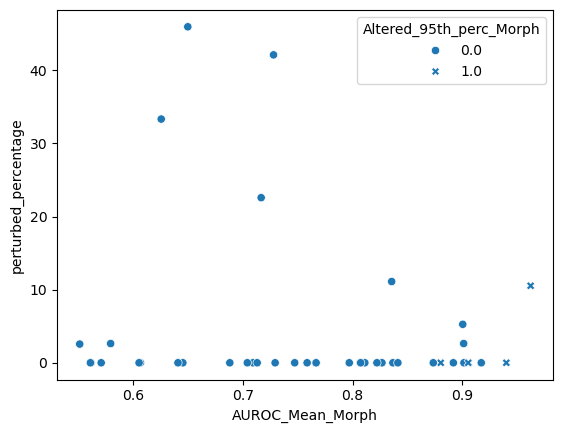

In [24]:
sns.scatterplot(data=img_dual_ppi_df.filter((pl.col("image_assayed"))&(pl.col("ppi_assayed"))).to_pandas(),
                x="AUROC_Mean_Morph",
                y="perturbed_percentage",
                style="Altered_95th_perc_Morph")

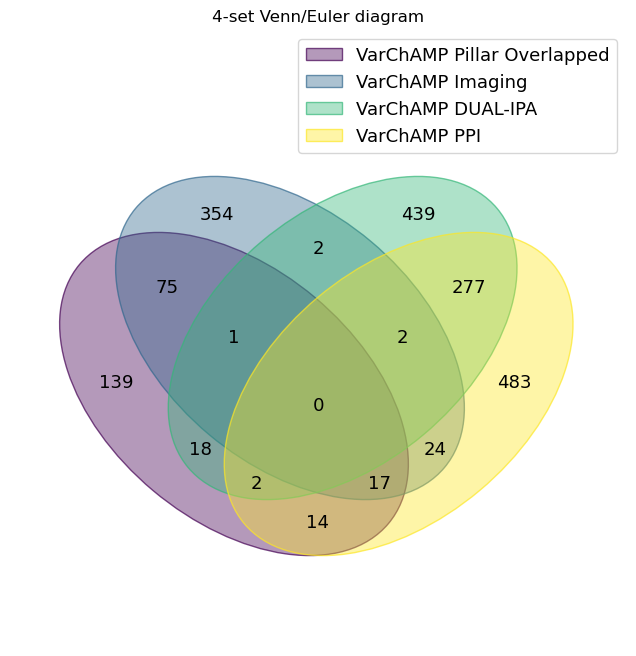

In [25]:
# Create the diagrams with your data
sets_data = {
    'VarChAMP Pillar Overlapped': set(varchamp_pillar_df.filter(pl.col("pillar_tested"))["gene_variant"].unique()),
    'VarChAMP Imaging': set(img_metric_df["gene_variant"].unique()), 
    'VarChAMP DUAL-IPA': set(dual_ipa_df["gene_variant"].unique()),
    'VarChAMP PPI': set(ppi_sum_df["gene_variant"].unique())
}

venn(sets_data)
plt.title("4‐set Venn/Euler diagram")
plt.show()

## 2. Functional Assay Mapping

In [26]:
def plot_gene_level_summary(df, hit_col, cell_change, ax=None):
    total_allele_hit_sum_df = (
        df
        .group_by("Gene")
        .agg([
            pl.len().alias("len"),
            pl.col(hit_col).filter(pl.col(hit_col)).len().alias("len_hits"),
        ])
        .with_columns(
            # compute percentage = hit_count / total_variants * 100
            (pl.col("len_hits") / pl.col("len") * 100)
            .round(1)
            .alias("pct_hits")
        )
        # sort by total_variants descending just for nicer plotting order
        .sort("len", descending=False)
    ).to_pandas()
    
    y = range(len(total_allele_hit_sum_df))
    n_genes = len(y)

    # 4. Dynamically scale figure size
    bar_width = 0.4
    if ax is None:
        fig_height = max(6, min(n_genes * 0.3, 40))  # cap size for huge plots
        fig_width = 8
        fig, ax = plt.subplots(figsize=(fig_width, fig_height))

    # Plot bars
    ax.barh(y, total_allele_hit_sum_df["len"], color="skyblue", label="# Variants")
    ax.barh(y, total_allele_hit_sum_df["len_hits"], color="tomato", label="# of Hits")

    # Annotate percentage
    for i, pct in enumerate(total_allele_hit_sum_df["pct_hits"]):
        ax.text(
            total_allele_hit_sum_df.loc[i, "len"] + 0.5,
            i,
            f"{pct:.1f}%",
            ha="left",
            va="center",
            fontsize=10 if n_genes > 20 else 11,
            rotation=0,
        )
    # Axis formatting
    ax.set_yticks(y)
    ax.set_yticklabels(
        total_allele_hit_sum_df["Gene"],
        fontsize=10 if n_genes > 20 else 11,
    )
    ax.set_xlabel("Count", fontsize=11)
    ax.set_title(
        f"{cell_change.upper()} Hits per Gene",
        fontsize=13,
    )
    ax.set_xlim(0, total_allele_hit_sum_df["len"].max() * 1.1)
    ax.legend(fontsize=11, loc="lower right")

### 2.1 Imaging

### 2.2 DUAL-IPA assay

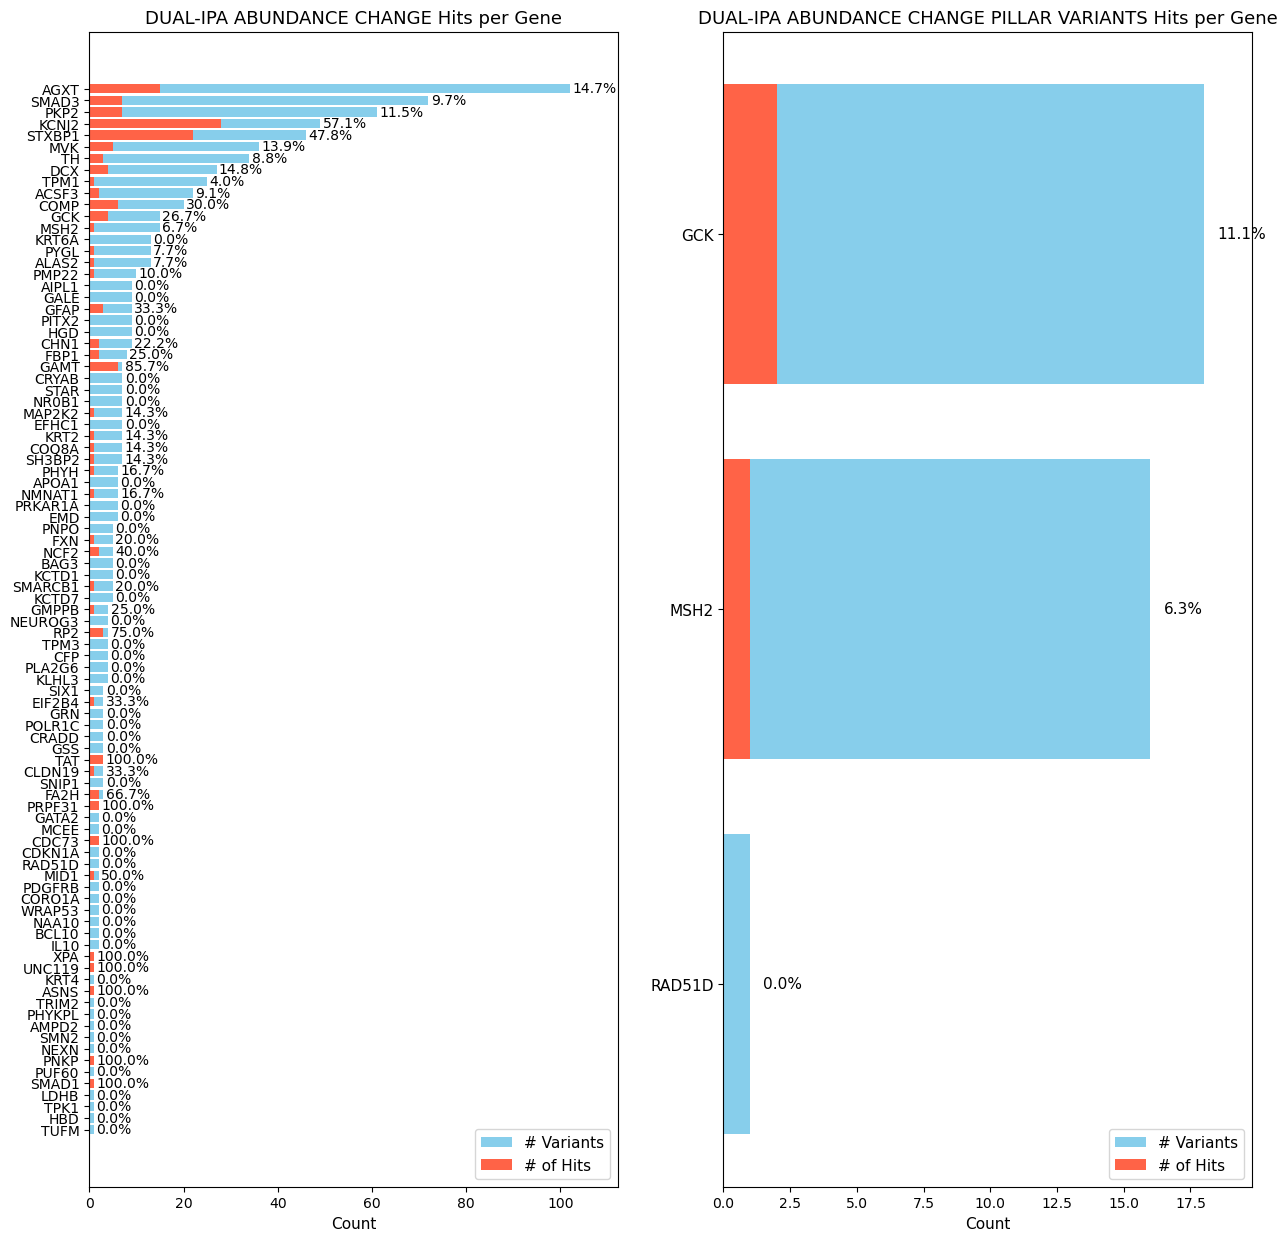

In [47]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
plot_gene_level_summary(dual_ipa_df.with_columns(
    pl.col("gene_variant").str.split("_").list.get(0).alias("Gene")
), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change", ax=ax[0])
plot_gene_level_summary(pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA"]), "DUALIPA_Abundance_Change", "DUAL-IPA Abundance Change Pillar Variants", ax=ax[1])

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""MSH2_Lys627Asn""",null,"""Loss of function""","""Abnormal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Low abundance ""","""Abnormal"""
"""MSH2_Gly40Ser""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""GCK_Ala456Val""","""Pathogenic""","""Decreased activity""","""Abnormal"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""Loss of function""","""Abnormal"""
"""MSH2_Ala714Val""","""Conflicting classifications of…","""Loss of function""","""Abnormal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""Loss of function""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""MSH2_Leu92Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Leu341Pro""","""Likely pathogenic""","""WT-like""","""Normal"""
"""MSH2_Leu440Pro""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Pro622Leu""","""Pathogenic""","""WT-like""","""Normal"""
"""MSH2_Thr335Ile""","""Uncertain significance""","""WT-like""","""Normal"""
"""MSH2_Glu562Val""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""MSH2_Ala305Thr""","""Conflicting classifications of…","""WT-like""","""Normal"""
"""GCK_Ala456Val""","""Pathogenic""","""Hyperactive""","""Not specified"""
"""MSH2_Arg524Pro""","""Likely pathogenic""","""WT-like""","""Normal"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala456Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Met251Thr""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala378Val""","""Pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Val253Ala""","""Conflicting classifications of…","""Synonymous""","""Abnormal"""
"""GCK_Met381Arg""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Arg377His""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


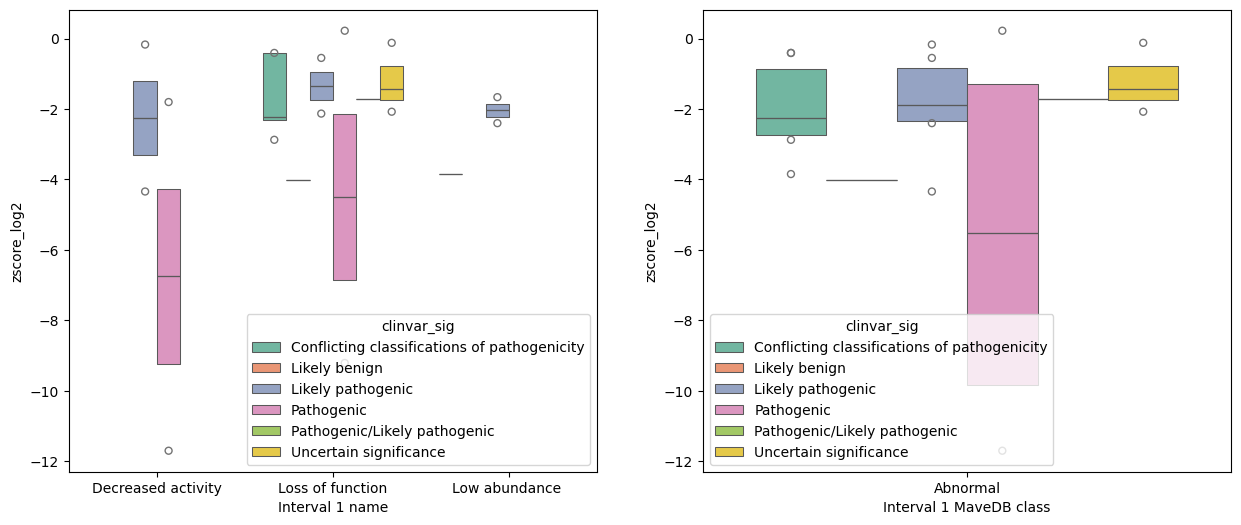

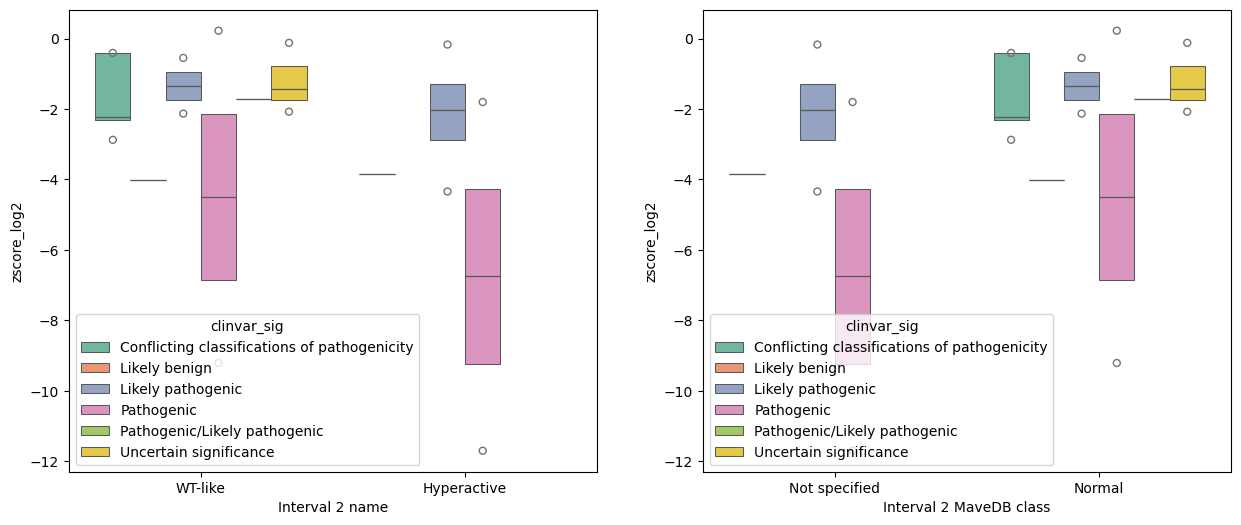

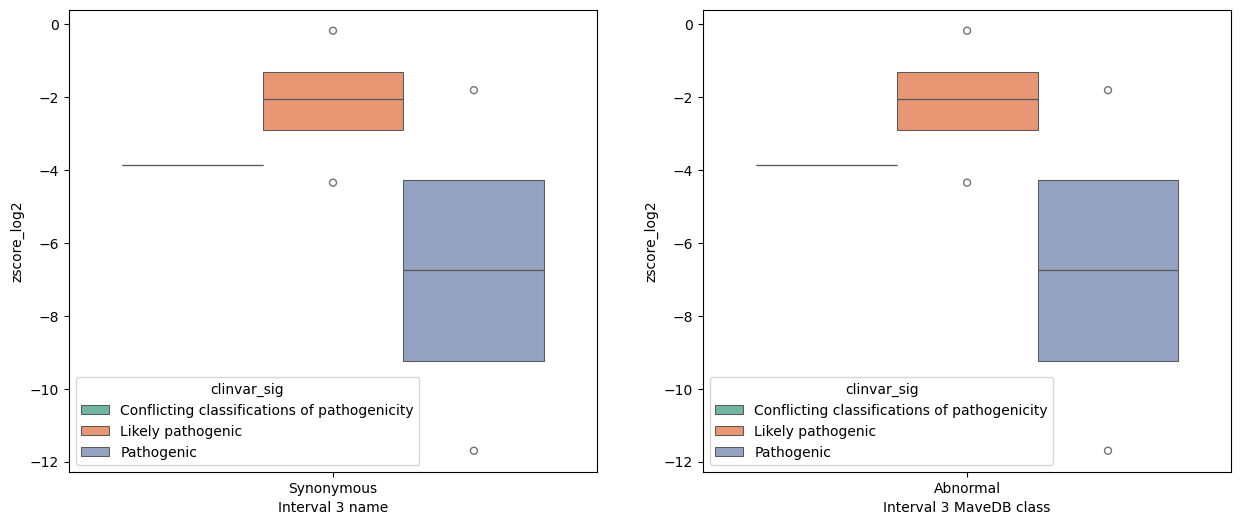

In [51]:
pl.Config.set_tbl_rows(25)  # Show all rows
# pl.Config.set_tbl_cols(40)  # Show all columns
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_DUALIPA",int_name, mavedb_name])
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores.unique(subset="gene_variant")["gene_variant","clinvar_sig",int_name, mavedb_name])
        fig, ax = plt.subplots(1,2,figsize=(15,6))
        hue_order = sorted(func_scores.drop_nulls("clinvar_sig").unique("clinvar_sig")["clinvar_sig"])
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=int_name,
            y=dual_ipa_metric,
            ax=ax[0],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )
        sns.boxenplot(
            data=func_scores.unique(subset="gene_variant").to_pandas(),
            x=mavedb_name,
            y=dual_ipa_metric,
            ax=ax[1],
            hue="clinvar_sig",
            dodge=True,
            palette="Set2",
            hue_order=hue_order
        )

### 2.3 PPI assays

In [56]:
for i in range(1,7):
    int_name = f"Interval {i} name"
    mavedb_name = f"Interval {i} MaveDB class"
    func_scores = pillar_img_dual_ppi_df.drop_nulls(subset=["Pillar_Set","VarChAMP_PPI",int_name, mavedb_name])
    # print(func_scores)
    # print(func_scores.filter(pl.col(int_name)=="Synonymous"))
    if func_scores.shape[0] > 0:
        display(func_scores["gene_variant","clinvar_sig",int_name, mavedb_name])
    # if func_scores.shape[0] > 0:
    #     fig, ax = plt.subplots(1,2,figsize=(12,6))
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=int_name,
    #         y="perturbed_percentage",
    #         ax=ax[0]
    #     )
    #     sns.boxenplot(
    #         data=func_scores.unique(subset="gene_variant").to_pandas(),
    #         x=mavedb_name,
    #         y="perturbed_percentage",
    #         ax=ax[1]
    #     )

gene_variant,clinvar_sig,Interval 1 name,Interval 1 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Low abundance ""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Decreased activity""","""Abnormal"""


gene_variant,clinvar_sig,Interval 2 name,Interval 2 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Hyperactive""","""Not specified"""


gene_variant,clinvar_sig,Interval 3 name,Interval 3 MaveDB class
str,str,str,str
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""
"""GCK_Ala387Glu""","""Likely pathogenic""","""Synonymous""","""Abnormal"""


In [57]:
ppi_df.filter(pl.col("gene_variant")=="GCK_Ala387Glu")

ad_orf_id,nt_change,final_score_wt,symbol,db_orf_id,edgotype,aa_change,final_score,ad_symbol,edgotype_wt_2,gene_variant,edgotype_wt_final,VarChAMP_PPI,total_occurrences,not_perturbed_count,inconclusive_count,perturbed_count,not_perturbed_percentage,inconclusive_percentage,perturbed_percentage
i64,str,i64,str,i64,str,str,i64,str,str,str,str,bool,i64,i64,i64,i64,f64,f64,f64
54784,"""1160C>A""",3,"""GCK""",3689,"""not perturbed""","""Ala387Glu""",3,"""GCKR""","""not perturbed""","""GCK_Ala387Glu""","""not perturbed""",true,2,1,0,1,50.0,0.0,50.0
70835,"""1160C>A""",4,"""GCK""",3689,"""perturbed""","""Ala387Glu""",0,"""SPDYE4""","""perturbed""","""GCK_Ala387Glu""","""perturbed""",true,2,1,0,1,50.0,0.0,50.0
